# Shapley values use case 2 (ADE)
### Investigating implicit knowledge of Llama using Shapley values for false negative predictions

In [1]:
# Loading libraries
import re, json, sys, subprocess, textwrap, ast
from pathlib import Path
from collections import defaultdict, namedtuple, OrderedDict
from tqdm.auto import tqdm
import pandas as pd
import torch
from unsloth.chat_templates import get_chat_template
from unsloth import FastLanguageModel
from transformers import BitsAndBytesConfig
from captum.attr import ShapleyValues, LLMAttribution, TextTemplateInput, FeatureAblation
import csv
import matplotlib.pyplot as plt

/beegfs/homes/prichter/venv_captum/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [3]:
# Important paths
CSV_PATH        = "/home/prichter/research/MIEQA/output_results_llama3_8b_i2b2_pydantic.csv"         # pipe-separated
MODEL_PATH      = "/prj/doctoral_letters/MIEQA/llms/Meta-Llama-3_1-8b_refined_i2b2_pydantic_noeval/"

# Load model

In [4]:
def load_llama(path:str):
    model, tok = FastLanguageModel.from_pretrained(path, max_seq_length=2048, load_in_4bit=True,)
    model = FastLanguageModel.for_inference(model).eval().cuda()
    tok.pad_token = tok.eos_token
    tok = get_chat_template(tok, chat_template="chatml")
    return model, tok

model, tokenizer = load_llama(MODEL_PATH)
llm_attr         = LLMAttribution(ShapleyValues(model), tokenizer)

==((====))==  Unsloth 2025.2.15: Fast Llama patching. Transformers: 4.46.1.
   \\   /|    GPU: Quadro RTX 6000. Max memory: 23.461 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Unsloth 2025.2.15 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.
Unsloth: Will map <|im_end|> to EOS = <|end_of_text|>.


Model does not have a padding token! Will use pad_token = <|finetune_right_pad_id|>.


# Helper functions

In [7]:
def escape_braces_except_placeholders(template):
    """
    Escape all braces in the system prompt except the placeholders of relation information
    
    Parameters:
    - system prompt
    
    Returns:
    - system prompt with escaped braces
    """
    result = ''
    i = 0
    while i < len(template):
        if template[i] == '{':
            if i + 1 < len(template) and template[i + 1] == '}':
                # This is a placeholder '{}', keep it as is
                result += '{}'
                i += 2
            else:
                # Escape the '{'
                result += '{{'
                i += 1
        elif template[i] == '}':
            # Escape the '}'
            result += '}}'
            i += 1
        else:
            result += template[i]
            i += 1
    return result

def replace_ade_with_placeholder(text_string, ade_substring, placeholder="{ade}"):
    """
    Replaces specified 'ade' substring with placeholder in a given input text.

    Parameters:
    - text_string: The original input text.
    - ade_substring: The substring to be replaced.
    - placeholder: The placeholder. Typically {ade}.

    Returns:
    - The modified input text with the all 'ade' replaced.
    """
    return text_string.replace(ade_substring, placeholder)

def get_ade_value_index_and_other_empty_string_indices(token_list):
    """
    Finds the index number of the first empty string token after relation information 'ade' (the FN), and a
    list of all other empty string tokens.
    
    Parameters:
    - token_list: the generated output of the LLM (list of sub-tokens).
    
    Returns:
    - A tuple containing:
       - ade_value_index (int): The index of the first empty string token
                                    that appears after 'ade'.
       - other_empty_string_indices (list): A list of all empty string indices, except ade_value_index.
    """
    ade_value_index = -1
    all_empty_string_indices_temp = []

    for i, token in enumerate(token_list):
      if token == "Ġ''," or token == "Ġ''":
        all_empty_string_indices_temp.append(i)

    try:
      ade_key_index = token_list.index("ade")
    
      for i in range(ade_key_index + 1, len(token_list)):
        if token_list[i] == "Ġ''," or token_list[i] == "Ġ''":
          ade_value_index = i
          break 
    except ValueError:
      pass 

    other_empty_string_indices = [
      idx for idx in all_empty_string_indices_temp if idx != ade_value_index
    ]
  
    return ade_value_index, other_empty_string_indices

# Parse FN ADE predictions and gold annotations

In [8]:
with open(CSV_PATH, 'r', newline='') as csvfile:
    reader = csv.DictReader(csvfile, delimiter='|')
    input_texts = []
    golds = []
    preds = []
    count = 0
    for id, row in enumerate(reader):
        text = row['text']
                
        gold = eval(row['gold'], {"OrderedDict": OrderedDict}, {})
        pred = eval(row['pred'], {"OrderedDict": OrderedDict}, {})

        if len(gold['medications']) == 1 and len(pred['medications']) == 1:
            if gold['medications'][0]['ade'] != '' and pred['medications'][0]['ade'] == '' \
                and isinstance(gold['medications'][0]['ade'], str):
                input_texts.append(text)
                golds.append(gold)
                preds.append(pred)
    
    count += 1

# Generate Shapley values for all input samples containing FN ADE

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


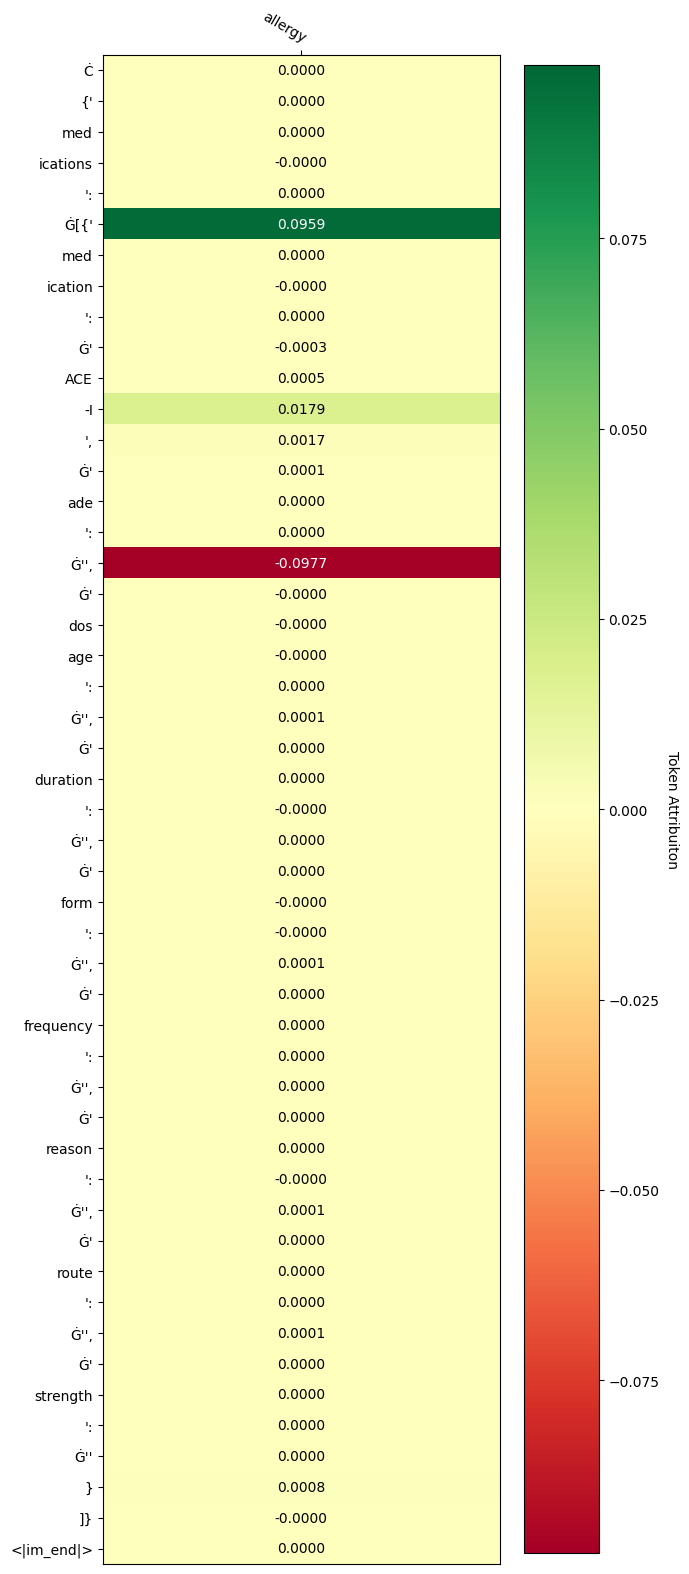

The index of 'Ġ'',' is: 16
The ADE Shapley value for 'Ġ'',' is: -0.09771728515625
['ade', "':", "Ġ'',", "Ġ'"]
The Other Shapley values for 'Ġ'',' are: [9.953975677490234e-05, 1.895427703857422e-05, 8.034706115722656e-05, 2.765655517578125e-05, 0.00011920928955078125, 0.00011181831359863281, 6.318092346191406e-06]
OrderedDict([('medications', [{'medication': 'ACE-I', 'ade': '', 'dosage': '', 'duration': '', 'form': '', 'frequency': '', 'reason': '', 'route': '', 'strength': ''}])])
OrderedDict([('medications', [{'medication': 'ACE-I', 'ade': 'allergy', 'dosage': '', 'duration': '', 'form': '', 'frequency': '', 'reason': '', 'route': '', 'strength': ''}])])
... was consistent with an ACE-I allergy rather than a C-1 ...
[-0.09771728515625]
[[9.953975677490234e-05, 1.895427703857422e-05, 8.034706115722656e-05, 2.765655517578125e-05, 0.00011920928955078125, 0.00011181831359863281, 6.318092346191406e-06]]
####### sample 0 #########


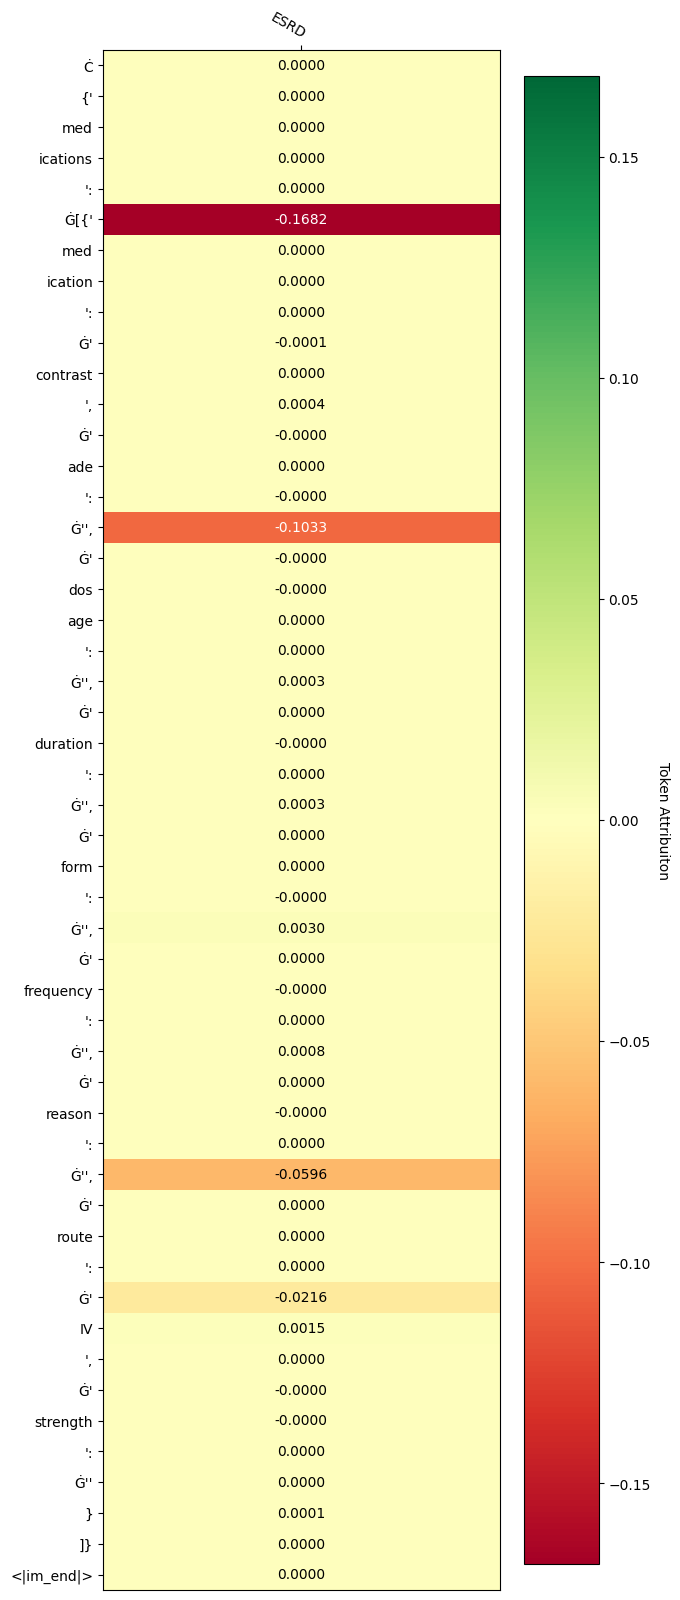

The index of 'Ġ'',' is: 15
The ADE Shapley value for 'Ġ'',' is: -0.103271484375
['ade', "':", "Ġ'',", "Ġ'"]
The Other Shapley values for 'Ġ'',' are: [0.00034809112548828125, 0.0002932548522949219, 0.003002166748046875, 0.0007982254028320312, -0.0595703125, 4.76837158203125e-06]
OrderedDict([('medications', [{'medication': 'contrast', 'ade': '', 'dosage': '', 'duration': '', 'form': '', 'frequency': '', 'reason': '', 'route': 'IV', 'strength': ''}])])
OrderedDict([('medications', [{'medication': 'contrast', 'ade': 'ESRD', 'dosage': '', 'duration': '', 'form': '', 'frequency': '', 'reason': '', 'route': 'IV', 'strength': ''}])])
... - ESRD on HD since [**2111**] after IV contrast for cath ...
[-0.09771728515625, -0.103271484375]
[[9.953975677490234e-05, 1.895427703857422e-05, 8.034706115722656e-05, 2.765655517578125e-05, 0.00011920928955078125, 0.00011181831359863281, 6.318092346191406e-06], [0.00034809112548828125, 0.0002932548522949219, 0.003002166748046875, 0.0007982254028320312, -0.0

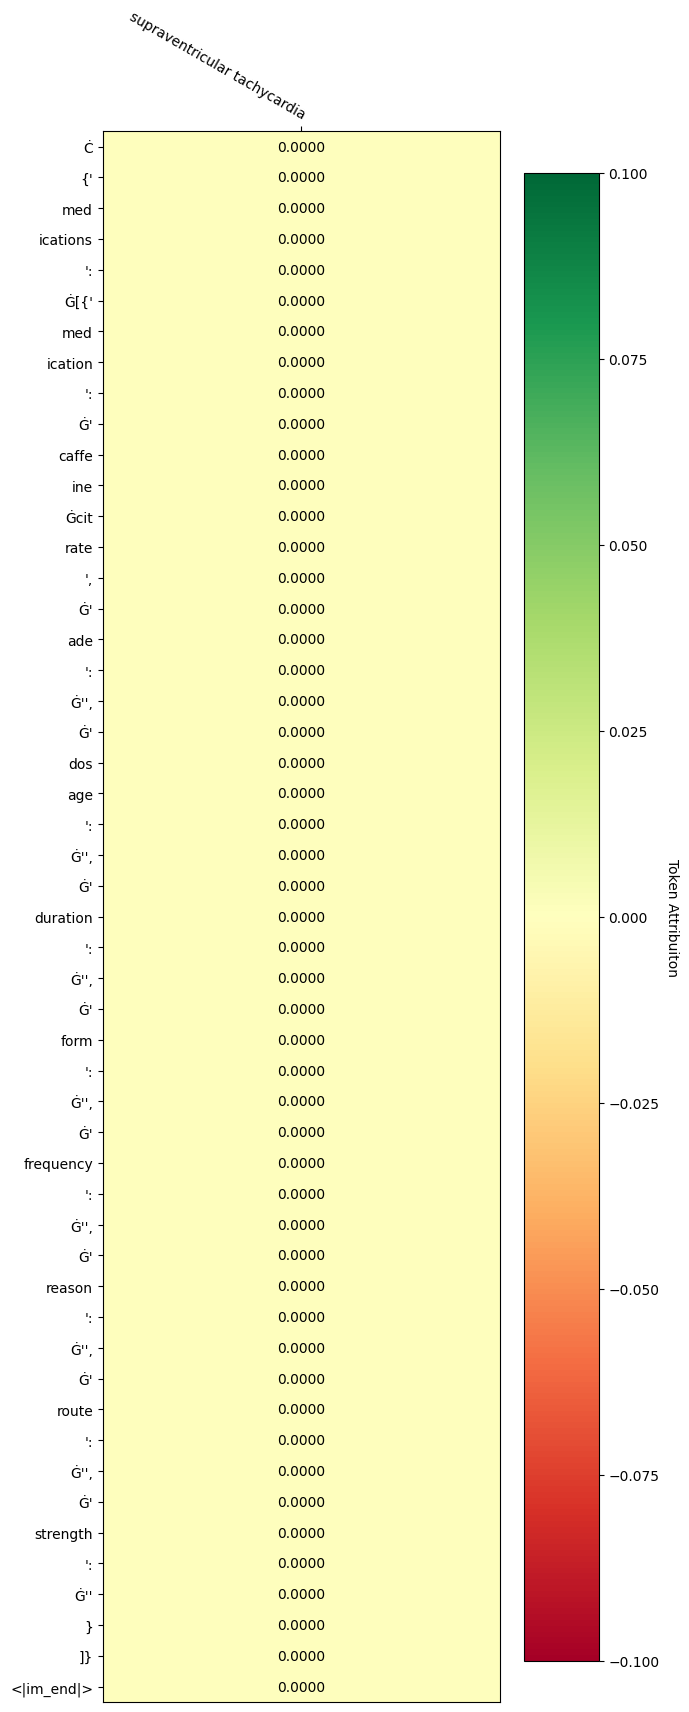

The index of 'Ġ'',' is: 18
The ADE Shapley value for 'Ġ'',' is: 0.0
['ade', "':", "Ġ'',", "Ġ'"]
The Other Shapley values for 'Ġ'',' are: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
OrderedDict([('medications', [{'medication': 'caffeine citrate', 'ade': '', 'dosage': '', 'duration': '', 'form': '', 'frequency': '', 'reason': 'supraventricular tachycardia', 'route': '', 'strength': ''}])])
OrderedDict([('medications', [{'medication': 'caffeine citrate', 'ade': 'supraventricular tachycardia', 'dosage': '', 'duration': '', 'form': '', 'frequency': '', 'reason': '', 'route': '', 'strength': ''}])])
... The infant did present with a brief period of supraventriculartachycardia on [**2197-10-17**], at which time caffeine citrate ...
[-0.09771728515625, -0.103271484375, 0.0]
[[9.953975677490234e-05, 1.895427703857422e-05, 8.034706115722656e-05, 2.765655517578125e-05, 0.00011920928955078125, 0.00011181831359863281, 6.318092346191406e-06], [0.00034809112548828125, 0.0002932548522949219, 0.003002166748046

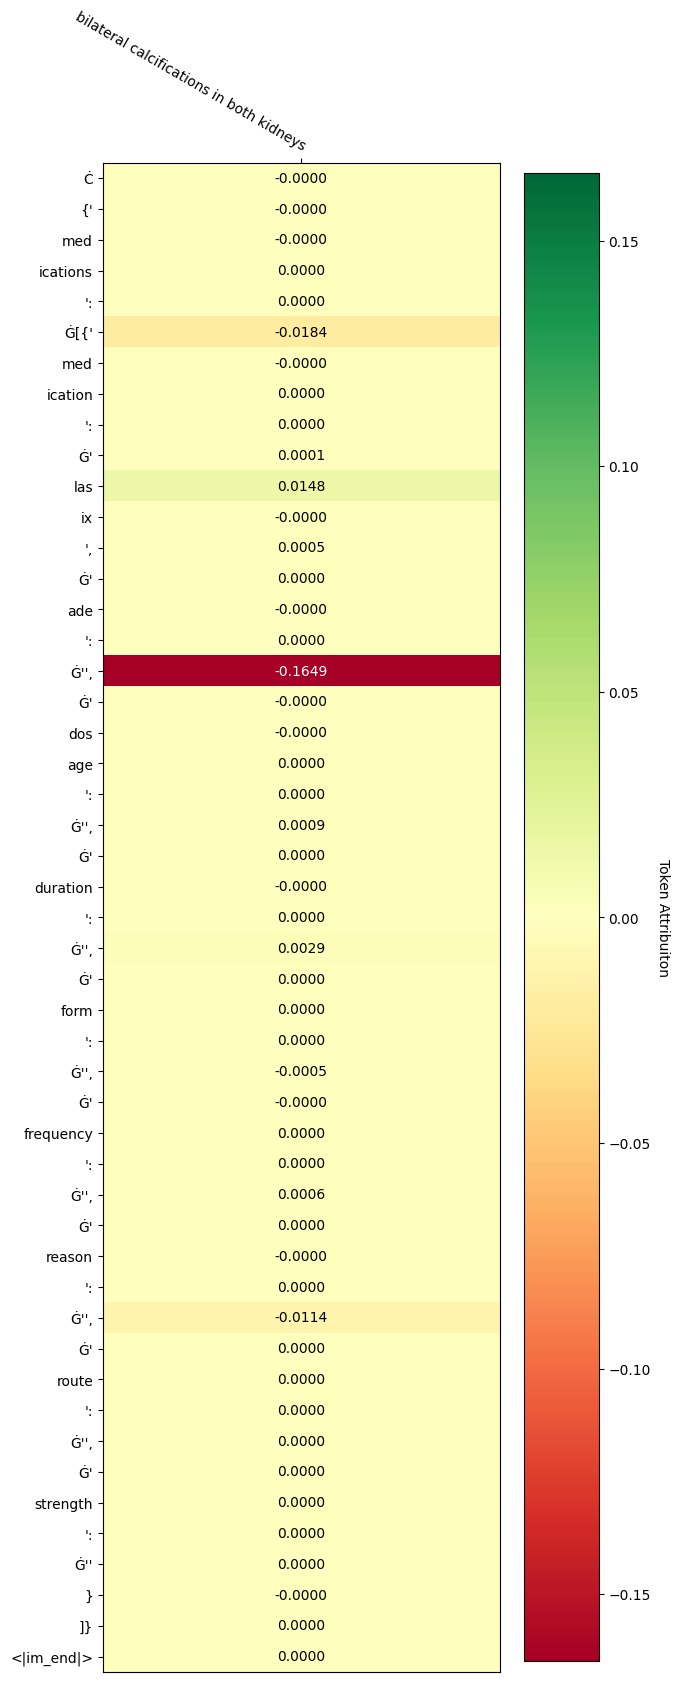

The index of 'Ġ'',' is: 16
The ADE Shapley value for 'Ġ'',' is: -0.1649169921875
['ade', "':", "Ġ'',", "Ġ'"]
The Other Shapley values for 'Ġ'',' are: [0.0009307861328125, 0.00292205810546875, -0.00046443939208984375, 0.0005998611450195312, -0.011444091796875, 1.239776611328125e-05, 4.1484832763671875e-05]
OrderedDict([('medications', [{'medication': 'lasix', 'ade': '', 'dosage': '', 'duration': '', 'form': '', 'frequency': '', 'reason': '', 'route': '', 'strength': ''}])])
OrderedDict([('medications', [{'medication': 'lasix', 'ade': 'bilateral calcifications in both kidneys', 'dosage': '', 'duration': 'chronic', 'form': '', 'frequency': '', 'reason': '', 'route': '', 'strength': ''}])])
... which showed bilateral calcifications in both kidneys, consistent ...  ... with chronic lasix use. ...
[-0.09771728515625, -0.103271484375, 0.0, -0.1649169921875]
[[9.953975677490234e-05, 1.895427703857422e-05, 8.034706115722656e-05, 2.765655517578125e-05, 0.00011920928955078125, 0.00011181831359863

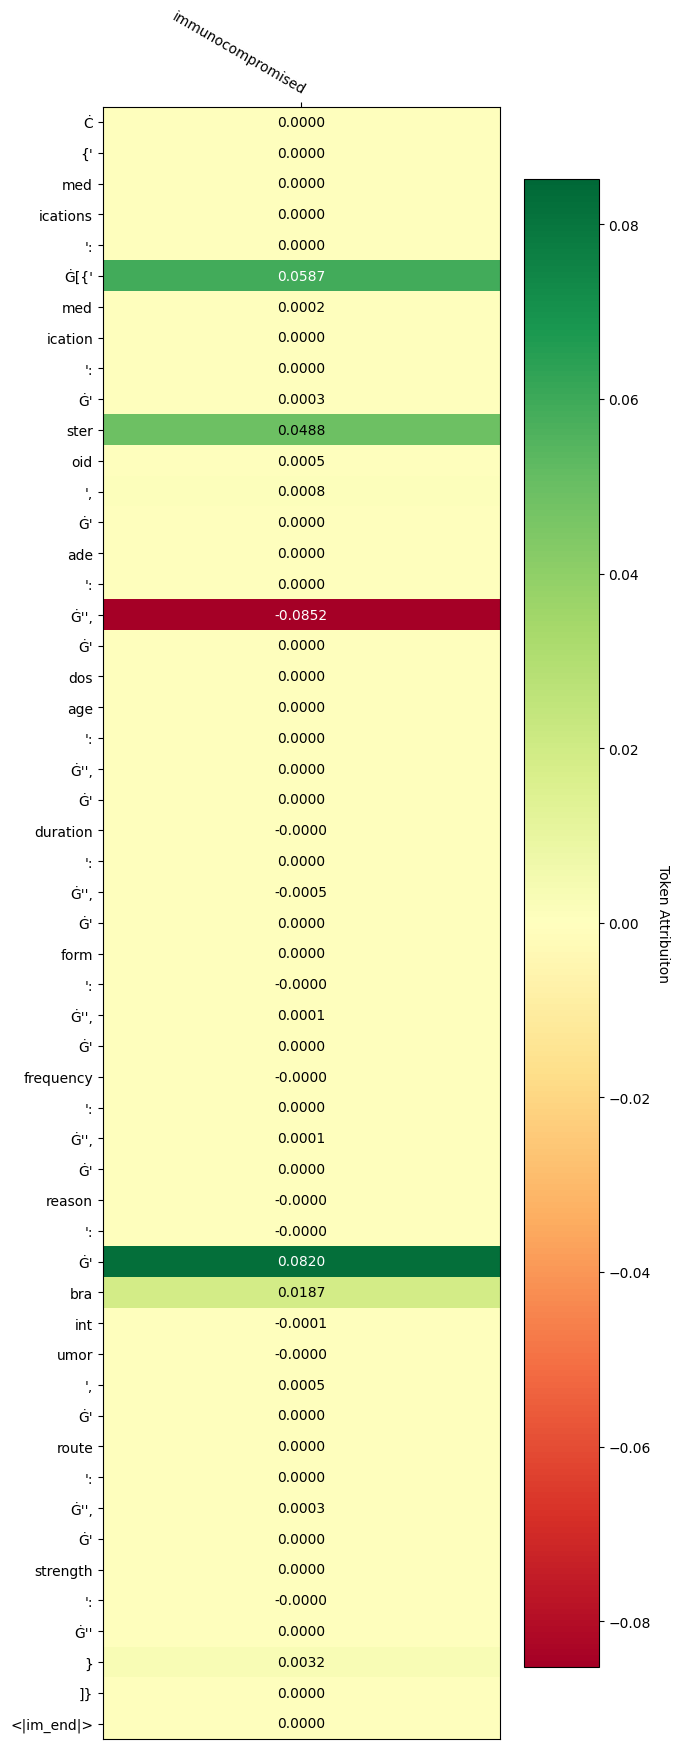

The index of 'Ġ'',' is: 16
The ADE Shapley value for 'Ġ'',' is: -0.085205078125
['ade', "':", "Ġ'',", "Ġ'"]
The Other Shapley values for 'Ġ'',' are: [1.9073486328125e-05, -0.0004901885986328125, 0.00014209747314453125, 0.0001239776611328125, 0.0002689361572265625, 2.372264862060547e-05]
OrderedDict([('medications', [{'medication': 'steroid', 'ade': '', 'dosage': '', 'duration': '', 'form': '', 'frequency': '', 'reason': 'brain tumor', 'route': '', 'strength': ''}])])
OrderedDict([('medications', [{'medication': 'steroid', 'ade': 'immunocompromised', 'dosage': '', 'duration': '', 'form': '', 'frequency': '', 'reason': 'brain tumor', 'route': '', 'strength': ''}])])
... out pneumococci.  Patient relatively immunocompromised due both ...  ... to cancer diagnosis and chronic steroid use secondary to braintumor. ...
[-0.09771728515625, -0.103271484375, 0.0, -0.1649169921875, -0.085205078125]
[[9.953975677490234e-05, 1.895427703857422e-05, 8.034706115722656e-05, 2.765655517578125e-05, 0.0001

In [9]:
# System prompt
template = '''<|im_start|>system
You are a physician. Your task is to extract ALL drug names (active ingredients or drug names) and their related information, such as ADE, strength, frequency, duration, route, form, dosage, and reason from a given text snippet of a doctoral letter. 
Please make sure to extract the medications **in the order they appear** in the text. Maintain this order in the JSON response.
If a medication occurs more than once in the text, append a unique count in parentheses to its name, starting from (1). 
If there is NO medication information in the text, create this JSON: {'medications': []}
ONLY respond with an instance of JSON without any additional information. You have access to a JSON schema, which will determine how the JSON should be structured.
Make sure to return ONLY an instance of the JSON, NOT the schema itself. Do not add any additional information.
JSON schema:
{"$defs": {"Medication": {"description": "Medication information extracted from the text.", "properties": {"medication": {"description": "A drug name or an active ingredient.", "title": "Medication", "type": "string"}, "ade": {"anyOf": [{"type": "string"}, {"items": {"type": "string"}, "type": "array"}, {"type": "null"}], "default": "", "description": "Extract adverse drug events from the text. Example: rash, hypotension, thrombocytopenia, toxicity, diarrhea, altered mental status, Rash, Thrombocytopenia, GI bleed, somnolent, etc.", "title": "Ade"}, "strength": {"anyOf": [{"type": "string"}, {"items": {"type": "string"}, "type": "array"}, {"type": "null"}], "default": "", "description": "Extract the strength of the medication from the text. Examples: 100 mg, 10 mg, 5 mg, 20 mg, 40 mg, 25 mg, 500 mg, 10mg, 50 mg, 5mg, etc.", "title": "Strength"}, "frequency": {"anyOf": [{"type": "string"}, {"items": {"type": "string"}, "type": "array"}, {"type": "null"}], "default": "", "description": "Extract the frequency of the medication from the text. Examples: 1-0-0, 1-0-1, daily, 0-0-1, DAILY (Daily), once a day, DAILY, BID, BID (2 times a day), twice a day, etc.", "title": "Frequency"}, "duration": {"anyOf": [{"type": "string"}, {"items": {"type": "string"}, "type": "array"}, {"type": "null"}], "default": "", "description": "Extract the duration of the medication from the text. Examples: dauerhaft, pausiert, abgesetzt, f\\u00fcr 12 Monate, B-DATE - B-DATE, Pause, dauerhafte, 14 day, for 7 days, for 10 days, etc.", "title": "Duration"}, "route": {"anyOf": [{"type": "string"}, {"items": {"type": "string"}, "type": "array"}, {"type": "null"}], "default": "", "description": "Extract the route of the medication from the text. Examples: PO, Oral, IV, by mouth, po, Inhalation, oral, drip, gtt, i.v., etc.", "title": "Route"}, "form": {"anyOf": [{"type": "string"}, {"items": {"type": "string"}, "type": "array"}, {"type": "null"}], "default": "", "description": "Extract the form of the medication from the text. Examples: Tablet, Capsule, Solution, Tablet, Delayed Release (E.C.), Tablets, Tablet, Chewable, tablet, Appl, Capsule, Delayed Release(E.C.), Tablet(s), etc.", "title": "Form"}, "dosage": {"anyOf": [{"type": "string"}, {"items": {"type": "string"}, "type": "array"}, {"type": "null"}], "default": "", "description": "Extract the dosage of the medication from the text. Examples: One (1), Two (2), 1, 1-2, 2, sliding scale, Three (3), 0.5, taper, 3, etc.", "title": "Dosage"}, "reason": {"anyOf": [{"type": "string"}, {"items": {"type": "string"}, "type": "array"}, {"type": "null"}], "default": "", "description": "Extract the reason of the medication from the text. Examples: pain, Antikoagulation, constipation, Thrombozytenaggregationshemmung, Stentverschlussprophylaxe, anxiety, pneumonia, Antibiose, duale Thrombozytenaggregationshemmung, wheezing, etc.", "title": "Reason"}}, "required": ["medication"], "title": "Medication", "type": "object"}}, "description": "A list of medication information extracted from the text.", "properties": {"medications": {"description": "A list of medications and their related information.", "items": {"$ref": "#/$defs/Medication"}, "title": "Medications", "type": "array"}}, "title": "MedicationInfo", "type": "object"}
<|im_end|>
'''
shap_vals = []
shap_others = []
counter = 0

for t, g, p in zip(input_texts[:5], golds[:5], preds[:5]):
    ade = g['medications'][0]['ade']
    prompt = "<|im_start|>user\n" + replace_ade_with_placeholder(t, ade) + "\n<|im_end|>\n<|im_start|>assistant"
    escaped_template = escape_braces_except_placeholders(template)
    escaped_template = escaped_template + prompt

    inp = TextTemplateInput(
        escaped_template,
        values={"ade": ade},
    )
    target = str(dict(p)) + "<|im_end|>"

    gen_args = {
        "max_length": 2048,      
        "do_sample": False,     
        "temperature": 1.0,  
        "top_p": 1.0,
    }
    attr_res = llm_attr.attribute(inp, target=None, gen_args=gen_args, num_trials=1)
    attr_res.plot_token_attr(show=True)

    ade_val_idx, other_empty_idx  = get_ade_value_index_and_other_empty_string_indices(attr_res.output_tokens)
    print(f"The index of 'Ġ'',' is: {ade_val_idx}")
    shap_ade = attr_res.token_attr[ade_val_idx]
    shap_vals.append(float(shap_ade))
    print(f"The ADE Shapley value for 'Ġ'',' is: {float(shap_ade)}")
    print(attr_res.output_tokens[ade_val_idx-2:ade_val_idx+2])
    shap_other = attr_res.token_attr[other_empty_idx]
    shap_other = [float(i) for i in shap_other]
    shap_others.append(shap_other)
    print(f"The Other Shapley values for 'Ġ'',' are: {shap_other}")
    #print(p)
    #print(g)
    #print(t)
    #print(shap_vals)
    #print(shap_others)
    #print('####### sample ' + str(counter) + ' #########')
    
    # Call the function without showing the plot to get the figure and axis
    fig, ax = attr_res.plot_token_attr(show=False)
    # Save the figure to a file
    fig.savefig('ade_attribution_plot_llama3_8b_4bit_i2b2_' + str(counter) )  # You can specify any file format, such as .pdf, .jpg, etc.
    # Close the figure to free memory
    plt.close(fig)

    counter += 1

In [10]:
# Safe all Shapley values for ADE empty string and the non-ADE empty strings
with open('ade_attributions_list.json', 'w') as f:
    json.dump(shap_vals, f, indent=4) # 'indent=4' makes the file easy to read

with open('other_ade_attributions_list.json', 'w') as f:
    json.dump(shap_others, f, indent=4) # 'indent=4' makes the file easy to read

# Analyze Shapley values

In [11]:
# Import libraries
import statistics
import numpy as np
from scipy import stats

In [13]:
with open('ade_attributions_list.json', 'r') as f:
     ade_values = json.load(f)
print(f"Loaded list: {ade}", len(ade))

with open('other_ade_attributions_list.json', 'r') as f:
     ade_other_values = json.load(f)
print(f"Loaded list: {ade_other_values}", len(ade_other_values))

ade_other_values_flat = [item for sublist in ade_other_values for item in sublist]

Loaded list: immunocompromised 17
Loaded list: [[9.953975677490234e-05, 1.895427703857422e-05, 8.034706115722656e-05, 2.765655517578125e-05, 0.00011920928955078125, 0.00011181831359863281, 6.318092346191406e-06], [0.00034809112548828125, 0.0002932548522949219, 0.003002166748046875, 0.0007982254028320312, -0.0595703125, 4.76837158203125e-06], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0009307861328125, 0.00292205810546875, -0.00046443939208984375, 0.0005998611450195312, -0.011444091796875, 1.239776611328125e-05, 4.1484832763671875e-05], [1.9073486328125e-05, -0.0004901885986328125, 0.00014209747314453125, 0.0001239776611328125, 0.0002689361572265625, 2.372264862060547e-05]] 5


In [14]:
# Calculate mean and median
# Calculate the mean
mean_ade_value = statistics.mean(ade_values)
mean_ade_other_value = statistics.mean(ade_other_values_flat)
print(f"Mean ade: {mean_ade_value}")
print(f"Mean ade other: {mean_ade_other_value}")

# Calculate the median
median_ade_value = statistics.median(ade_values)
median_ade_other_value = statistics.median(ade_other_values_flat)
print(f"Median ade: {median_ade_value}")
print(f"Median ade other: {median_ade_other_value}")

Mean ade: -0.09022216796875
Mean ade other: -0.0018780086979721532
Median ade: -0.09771728515625
Median ade other: 2.372264862060547e-05


In [15]:
# Statistical significance
import numpy as np
from scipy import stats

# Define significance level
alpha = 0.05

# 1. Check for Homogeneity of Variances using Levene's Test
#    H0: Variances are equal.
#    If p-value < alpha, we reject H0 (variances are unequal).
levene_statistic, levene_pvalue = stats.levene(ade_values, ade_other_values_flat)

# Determine whether to assume equal variances for the t-test
equal_variances = True if levene_pvalue >= alpha else False

print(f"Levene's Test for Homogeneity of Variances:")
print(f"  Statistic: {levene_statistic:.6f}")
print(f"  P-value: {levene_pvalue:.6f}")
print(f"  Decision: {'Assume equal variances (Students t-test)' if equal_variances else 'Assume unequal variances (Welchs t-test)'}")

# 2. Perform the Independent Two-Sample T-Test
#    Hypothesis: Mean of ade_values < Mean of ade_other_values
t_statistic, p_value = stats.ttest_ind(
    a=ade_values,
    b=ade_other_values_flat,
    equal_var=equal_variances,
    alternative='less'
)

print("\nIndependent Two-Sample T-Test Results:")
print(f"  T-statistic: {t_statistic:.6f}")
print(f"  P-value: {p_value:.6f}")

# 3. Interpret the result
print(f"\nInterpretation (at alpha={alpha}):")
if p_value < alpha:
    print("  Reject the Null Hypothesis.")
    print("  There is statistically significant evidence that 'ade' values are more negative (mean is less) than 'ade other' values.")
else:
    print("  Fail to Reject the Null Hypothesis.")
    print("  There is not enough statistically significant evidence to conclude that 'ade' values are more negative than 'ade other' values.")

Levene's Test for Homogeneity of Variances:
  Statistic: 16.458365
  P-value: 0.000255
  Decision: Assume unequal variances (Welchs t-test)

Independent Two-Sample T-Test Results:
  T-statistic: -3.334471
  P-value: 0.014282

Interpretation (at alpha=0.05):
  Reject the Null Hypothesis.
  There is statistically significant evidence that 'ade' values are more negative (mean is less) than 'ade other' values.
